# Import

In [4]:
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random



# Configuration

In [ ]:
# --- Configuration ---
SATELLITE_IMAGE_PATH =r"C:\Users\dell\Downloads\Wayanad_4Band_Image_2023_v2.tif"
FOREST_MASK_PATH = r"C:\Users\dell\Downloads\Wayanad_Forest_Mask_2023_v2.tif"
PATCH_SIZE = 16
BATCH_SIZE = 64
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Generating Patches

In [8]:

class SatellitePatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_path, mask_path, pixel_coords, patch_size, batch_size):
        self.image_path = image_path
        self.mask_path = mask_path
        self.pixel_coords = pixel_coords
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.pad_width = self.patch_size // 2

    def __len__(self):
        return math.ceil(len(self.pixel_coords) / self.batch_size)

    def __getitem__(self, idx):
        batch_coords = self.pixel_coords[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.zeros((len(batch_coords), self.patch_size, self.patch_size, 4), dtype=np.float32)
        batch_y = np.zeros(len(batch_coords), dtype=np.uint8)

        with rasterio.open(self.image_path) as src_img, rasterio.open(self.mask_path) as src_mask:
            for i, (y, x) in enumerate(batch_coords):
                batch_y[i] = src_mask.read(1, window=rasterio.windows.Window(x, y, 1, 1))[0, 0]
                window = rasterio.windows.Window(x - self.pad_width, y - self.pad_width, self.patch_size, self.patch_size)
                patch = src_img.read(window=window, boundless=True, fill_value=0).astype(np.float32)
                
                # Ensure data cleanliness
                patch = np.nan_to_num(patch, nan=0.0, posinf=0.0, neginf=0.0)
                patch = np.clip(patch, 0, 4000) / 4000.0
                patch = np.moveaxis(patch, 0, -1)
                batch_x[i] = patch
        return batch_x, batch_y

In [10]:


print("Step 1: Setting up BALANCED coordinates by sampling...")

# --- NEW: Define how many samples we want PER CLASS ---
SAMPLES_PER_CLASS_TRAIN = 200000  # e.g., 200k Forest, 200k Non-Forest for training
SAMPLES_PER_CLASS_VAL = 50000    # e.g., 50k Forest, 50k Non-Forest for validation

# Open the mask and separate coordinates by class
print("Reading mask to separate Forest and Non-Forest coordinates...")
with rasterio.open(FOREST_MASK_PATH) as src:
    mask = src.read(1)
    
forest_coords = []
non_forest_coords = []

height, width = mask.shape
for y in range(height):
    for x in range(width):
        if mask[y, x] == 1:
            forest_coords.append((y, x))
        else:
            non_forest_coords.append((y, x))

print(f"Found {len(forest_coords):,} Forest pixels.")
print(f"Found {len(non_forest_coords):,} Non-Forest pixels.")

# --- Create a balanced training set ---
# Shuffle each list to ensure randomness
random.shuffle(forest_coords)
random.shuffle(non_forest_coords)

# Take the desired number of samples from each list
train_coords_forest = forest_coords[:SAMPLES_PER_CLASS_TRAIN]
train_coords_non_forest = non_forest_coords[:SAMPLES_PER_CLASS_TRAIN]

# Combine and shuffle them to mix them up
train_coords = train_coords_forest + train_coords_non_forest
random.shuffle(train_coords)

# --- Create a balanced validation set ---
# Use the *next* set of coordinates to ensure no overlap with training data
val_coords_forest = forest_coords[SAMPLES_PER_CLASS_TRAIN : SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_VAL]
val_coords_non_forest = non_forest_coords[SAMPLES_PER_CLASS_TRAIN : SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_VAL]

val_coords = val_coords_forest + val_coords_non_forest
random.shuffle(val_coords)

print("\n--- Balanced Data Split Summary ---")
print(f"Total training samples: {len(train_coords):,}")
print(f"Total validation samples: {len(val_coords):,}")

# Let's calculate the new expected steps per epoch
# BATCH_SIZE should be defined in your configuration block (e.g., BATCH_SIZE = 64)
new_steps_per_epoch = math.ceil(len(train_coords) / BATCH_SIZE)
print(f"\nNEW expected steps per epoch: {new_steps_per_epoch}")

Step 1: Setting up BALANCED coordinates by sampling...
Reading mask to separate Forest and Non-Forest coordinates...
Found 13,251,631 Forest pixels.
Found 30,157,399 Non-Forest pixels.

--- Balanced Data Split Summary ---
Total training samples: 400,000
Total validation samples: 100,000

NEW expected steps per epoch: 6250


In [16]:
train_generator = SatellitePatchGenerator(
    SATELLITE_IMAGE_PATH,
    FOREST_MASK_PATH,
    train_coords,
    patch_size=PATCH_SIZE,
    batch_size=BATCH_SIZE
)

val_generator = SatellitePatchGenerator(
    SATELLITE_IMAGE_PATH,
    FOREST_MASK_PATH,
    val_coords,
    patch_size=PATCH_SIZE,
    batch_size=BATCH_SIZE
)

# CNN Model

In [18]:
# Block 5 (FINAL & STABLE): Build and Compile the Model without Batch Normalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

print("\nStep 2 & 3: Building the FINAL, STABLE CNN model...")

# --- Model Building (No Batch Normalization for Maximum Stability) ---
model = Sequential([
    Input(shape=(PATCH_SIZE, PATCH_SIZE, 4)),

    # Block 1
    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    # BatchNormalization() has been REMOVED
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    # BatchNormalization() has been REMOVED
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    # BatchNormalization() has been REMOVED
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    # Dense layers for classification
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    
    # Output layer
    Dense(1, activation='sigmoid')
])
print("\nCompiling the model with final safe settings...")
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0), # Safe learning rate + gradient clipping
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model built and compiled successfully.")
model.summary()


Step 2 & 3: Building the FINAL, STABLE CNN model...

Compiling the model with final safe settings...
Model built and compiled successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,329 (622.38 KB)

 Trainable params: 159,329 (622.38 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
print("\nStep 4: Training the model with generators...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Start with fewer epochs as each epoch now processes the full dataset
    verbose=1
)


Step 4: Training the model with generators...


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4225s 676ms/step - accuracy: 0.9251 - loss: 0.1945 - val_accuracy: 0.9573 - val_loss: 0.1032
Epoch 2/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4439s 709ms/step - accuracy: 0.9589 - loss: 0.1002 - val_accuracy: 0.9633 - val_loss: 0.0897
Epoch 3/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4593s 734ms/step - accuracy: 0.9646 - loss: 0.0862 - val_accuracy: 0.9685 - val_loss: 0.0764
Epoch 4/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4904s 783ms/step - accuracy: 0.9683 - loss: 0.0771 - val_accuracy: 0.9708 - val_loss: 0.0710
Epoch 5/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5170s 824ms/step - accuracy: 0.9715 - loss: 0.0695 - val_accuracy: 0.9727 - val_loss: 0.0669


# Evaluation


Step 5: Evaluating the model...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 877s 561ms/step

Final Model Accuracy on Validation Data: 97.27%

Classification Report:
              precision    recall  f1-score   support

  Non-Forest       0.98      0.97      0.97     50000
      Forest       0.97      0.98      0.97     50000

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000


Confusion Matrix:


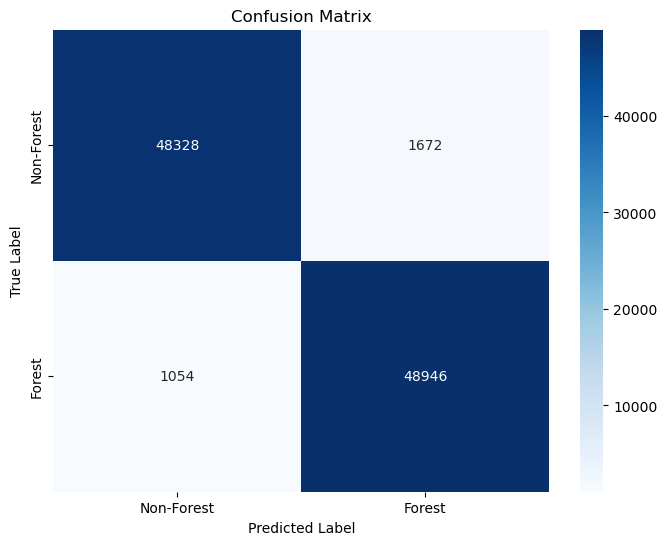

In [21]:
print("\nStep 5: Evaluating the model...")

# Get predictions from the validation generator
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# We need to get the true labels from the generator to compare
y_true = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]
    y_true.extend(labels)
y_true = np.array(y_true)

# The number of predictions might be slightly larger than true labels if the dataset
# size isn't perfectly divisible by the batch size. Trim to match.
y_pred = y_pred[:len(y_true)]

# Calculate and print metrics
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"\nFinal Model Accuracy on Validation Data: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Forest', 'Forest']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Forest', 'Forest'], yticklabels=['Non-Forest', 'Forest'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
# --- Step 8: Save the Trained Model for Future Use ---

MODEL_SAVE_PATH = 'forest_cover_cnn_model.keras'
print(f"\nSaving trained model to {MODEL_SAVE_PATH}...")

# Use the 'history' object from model.fit to ensure training is complete before saving
model.save(MODEL_SAVE_PATH)

print(f"Model saved successfully to {MODEL_SAVE_PATH}")


Saving trained model to forest_cover_cnn_model.keras...
Model saved successfully to forest_cover_cnn_model.keras


# Unseen Data Performance

In [38]:
import numpy as np
import rasterio
import tensorflow as tf
import math
from rasterio.windows import Window

# --- Configuration for Inference ---
MODEL_PATH = 'forest_cover_cnn_model.keras'        # Path to your saved model
IMAGE_2019_PATH = r"C:\Users\dell\Downloads\Wayanad_4Band_Image_2019.tif" # IMPORTANT: Update this path
OUTPUT_MAP_2019_PATH = r"C:\Users\dell\Downloads\output.tif" # Where to save the output

PATCH_SIZE = 16  # Must be the SAME as the patch size used for training!

In [28]:
print(f"Loading model from {MODEL_PATH}...")
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

Loading model from forest_cover_cnn_model.keras...
Model loaded successfully.


In [184]:
import numpy as np
import rasterio

# Path for input and output
IMAGE_2019_PATH = r"C:\Users\dell\Downloads\Wayanad_4Band_Image_2019.tif"  # Example input path
output_map_path = r"C:\Users\dell\Downloads\output.tif"

# Assuming model and PATCH_SIZE are already defined in your context

print(f"Starting prediction on {IMAGE_2019_PATH}...")

# Open the source image and get its metadata
with rasterio.open(IMAGE_2019_PATH) as src:
    # Get metadata to create a similar output file
    meta = src.meta.copy()
    meta.update(count=1, dtype='uint8', compress='lzw')  # Our output is a single band, 8-bit map

    # Create the output file
    with rasterio.open(output_map_path, 'w', **meta) as dst:
        # Process the image in blocks (tiles)
        num_blocks = len(list(src.block_windows(1)))
        current_block = 0
        
        for ji, window in src.block_windows(1):
            current_block += 1
            print(f"  Processing block {current_block}/{num_blocks}...")

            # Read the image data for the current block
            block_data = src.read(window=window)
            
            # --- Pre-processing ---
            # 1. Normalize the block data exactly as in training
            block_data = np.clip(block_data, 0, 4000) / 4000.0
            block_data = block_data.astype(np.float32)
            # 2. Transpose from (band, h, w) to (h, w, band)
            block_data = np.moveaxis(block_data, 0, -1)
            
            # --- Patch Creation ---
            # Pad the block to handle edges when creating patches
            pad_width = PATCH_SIZE // 2
            padded_block = np.pad(block_data, 
                                  [(pad_width, pad_width), (pad_width, pad_width), (0, 0)], 
                                  mode='constant', constant_values=0)
            
            patches = []
            block_h, block_w, _ = block_data.shape
            for y in range(block_h):
                for x in range(block_w):
                    patch = padded_block[y : y + PATCH_SIZE, x : x + PATCH_SIZE, :]
                    patches.append(patch)
            
            patches = np.array(patches)

            # --- Prediction ---
            # Predict in batches to avoid overwhelming GPU/CPU memory
            predictions = model.predict(patches, batch_size=256, verbose=0)
            class_labels = (predictions > 0.5).astype(np.uint8)
            
            # --- Reshape and Write ---
            # Reshape the flat list of labels back into a 2D map
            output_map = class_labels.reshape(block_h, block_w)
            
            # Write the resulting map to the correct location in the output file
            dst.write(output_map, 1, window=window)

print(f"\nPrediction complete. Output map saved to:\n{output_map_path}")

Starting prediction on C:\Users\dell\Downloads\Wayanad_4Band_Image_2019.tif...
  Processing block 1/667...
  Processing block 2/667...
  Processing block 3/667...
  Processing block 4/667...
  Processing block 5/667...
  Processing block 6/667...
  Processing block 7/667...
  Processing block 8/667...
  Processing block 9/667...
  Processing block 10/667...
  Processing block 11/667...
  Processing block 12/667...
  Processing block 13/667...
  Processing block 14/667...
  Processing block 15/667...
  Processing block 16/667...
  Processing block 17/667...
  Processing block 18/667...
  Processing block 19/667...
  Processing block 20/667...
  Processing block 21/667...
  Processing block 22/667...
  Processing block 23/667...
  Processing block 24/667...
  Processing block 25/667...
  Processing block 26/667...
  Processing block 27/667...
  Processing block 28/667...
  Processing block 29/667...
  Processing block 30/667...
  Processing block 31/667...
  Processing block 32/667...
  

In [186]:
import numpy as np
import rasterio

# Path to the output map
output_map_path = r"C:\Users\dell\Downloads\output.tif"

# Open the output map
with rasterio.open(output_map_path) as src:
    # Read the data
    output_data = src.read(1)  # Read the first band

    # Count forest pixels (assuming forest is represented by 1)
    forest_pixel_count = np.sum(output_data == 1)

print(f"Total number of forest pixels: {forest_pixel_count}")

Total number of forest pixels: 20619808


# Forest Cover in 2019

In [188]:
# Example of correctly calculating the forest cover area
pixel_width = 10  # Example value, in meters
pixel_height = 10  # Example value, in meters
area_per_pixel = pixel_width * pixel_height  # In square meters

forest_pixel_count = forest_pixel_count
total_area_sq_km = (forest_pixel_count * area_per_pixel) / 1_000_000

print(f"Pixel resolution: {pixel_width}m x {pixel_height}m")
print(f"Area per pixel: {area_per_pixel} sq. meters")
print(f"Number of forest pixels found: {forest_pixel_count}")

print(f"--- Final Result ---")
print(f"Total Forest Cover in 2019: {total_area_sq_km:.2f} square kilometers")

Pixel resolution: 10m x 10m
Area per pixel: 100 sq. meters
Number of forest pixels found: 20619808
--- Final Result ---
Total Forest Cover in 2019: 2061.98 square kilometers


In [113]:
!pip install geopandas matplotlib

# Generating masked image

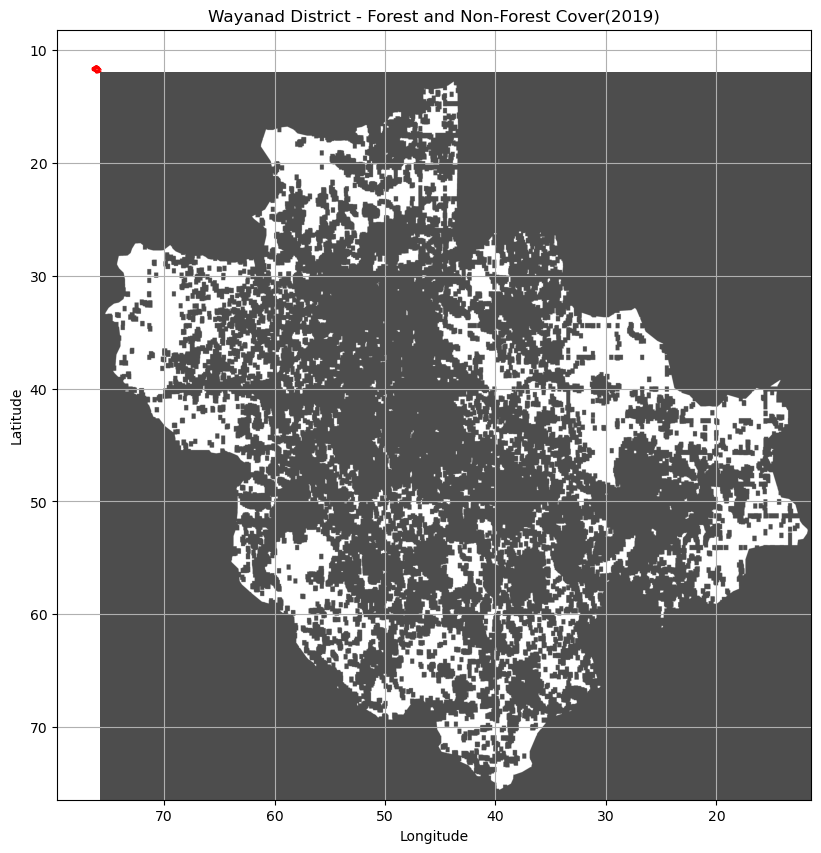

In [177]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
from skimage.morphology import remove_small_objects
import rasterio

# Paths
shapefile_path = r"C:\Users\dell\Documents\ArcGIS\Wayanad_Boundary\Wayanad_Boundary.shp"
output_map_path = r"C:\Users\dell\Downloads\Wayanad_Forest_Map.tif"  # OUTPUT_MAP_2019_PATH

# Load the shapefile
district_map = gpd.read_file(shapefile_path)

# Load output map using Rasterio
with rasterio.open(output_map_path) as src:
    # Read the data
    predictions = src.read(1)  # Read the first band

# Ensure predictions size (predictions.shape) matches your patch logic

# Gaussian smoothing and thresholding
smoothed_predictions = gaussian_filter(predictions, sigma=5)
threshold = 0.5
binary_mask = (smoothed_predictions > threshold).astype(np.uint8)

# Refine mask
cleaned_mask = remove_small_objects(binary_mask.astype(bool), min_size=100)
cleaned_mask = binary_opening(cleaned_mask, structure=np.ones((3, 3)))
cleaned_mask = binary_closing(cleaned_mask, structure=np.ones((3, 3)))

# Plot the district map and refined mask
plt.figure(figsize=(10, 10))
plt.imshow(cleaned_mask, extent=district_map.total_bounds, cmap='gray', alpha=0.7)
district_map.boundary.plot(ax=plt.gca(), edgecolor='red', linewidth=2)
plt.title('Wayanad District - Forest and Non-Forest Cover(2019)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()